# Warp Core Tutorial: Points

In [1]:
import numpy as np
A = np.array([[1, 2], [3, 4]])
B = np.array([5, 6])
C = np.array([[5],[6]])
matrix_product = np.dot(A, B)  # 矩阵乘法
print(matrix_product)
print(C)
b = A * B
dam = np.dot(A,C)
print(dam)

mn = A @ C
print(mn)

[17 39]
[[5]
 [6]]
[[17]
 [39]]
[[17]
 [39]]


In [2]:
import numpy as np
import warp as wp

wp.config.quiet = True

# Explicitly initializing Warp is not necessary but
# we do it here to ensure everything is good to go.
wp.init()

# Everything else is solely to visualize the results.
import IPython
import matplotlib
import matplotlib.animation
import matplotlib.pyplot
import pyglet

import warp.render

matplotlib.pyplot.rc("animation", html="jshtml")
pyglet.options["headless"] = True

import sys
if "google.colab" in sys.modules:
    print(
        "Rendering OpenGL instances with `glDrawElementsInstanced` "
        "is *extremely* slow in Google Colab, so it may take a few minutes "
        "to render the snippets from this notebook."
    )

Warp UserWarning: Python 3.9 or newer is recommended for running Warp, detected sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)


## Point Queries

When dealing with collections of points, a common operation is to query the neighbouring points to a given position, which can quickly become expensive as the number of points grow.

To speed-up these queries, Warp exposes a hash grid spatial structure that can be initialized using `wp.HashGrid()` and then rebuilt at each step based on the current point position with a call to the `wp.HashGrid.build()` method.

Instances of `wp.HashGrid` can then be passed to kernels using a `wp.uint64` integer representing their unique IDs, and the built-in `wp.hash_grid_query()` can be called there to iterate over the closest points.

[array([[[0., 0., 0.]],

       [[0., 0., 0.]]]), array([[[0., 0., 0.]],

       [[2., 2., 2.]]]), array([[[0. , 1.5, 3. ]],

       [[0. , 1.5, 3. ]]])]
[0.  1.5 3. ]
[0.]
[0. 2.]
[array([[[1]]]), array([[[2]]]), array([[[1]]])]


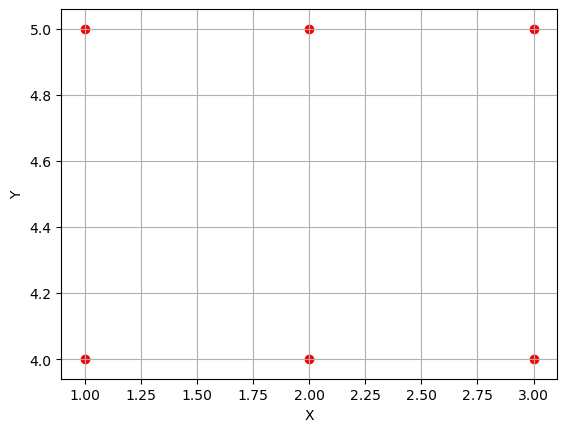

In [3]:
points = np.meshgrid(
    np.linspace(0, 1, 1),
    np.linspace(0, 2, 2),
    np.linspace(0, 3, 3),
)
print(points)

print(np.linspace(0, 3, 3))
print(np.linspace(0, 1, 1))
print(np.linspace(0, 2, 2))

print(np.meshgrid(1,2,1))


import matplotlib.pyplot as plt

x = np.array([1, 2, 3])
y = np.array([4, 5])
X, Y = np.meshgrid(x, y)

plt.scatter(X, Y, color="red")  # 画出网格点
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.show()


In [11]:
arr = wp.vec3((1, 2, 3))
sss = wp.length(arr)
print(sss)

3.7416574954986572


In [ ]:
"""Compute"""

@wp.func
def contact_force(
    n: wp.vec3,
    v: wp.vec3,
    c: float,
    k_n: float,
    k_d: float,
    k_f: float,
    k_mu: float,
) -> wp.vec3:
    vn = wp.dot(n, v) 
    jn = c * k_n
    jd = min(vn, 0.0) * k_d

    # contact force
    fn = jn + jd

    # friction force
    vt = v - n * vn
    vs = wp.length(vt)

    if vs > 0.0:
        vt = vt / vs

    # Coulomb condition
    ft = wp.min(vs * k_f, k_mu * wp.abs(fn))

    # total force
    return -n * fn - vt * ft


@wp.kernel
def update(
    grid: wp.uint64,
    particle_x: wp.array(dtype=wp.vec3), #一个array里面，每一个element是 wp.vector。这个array就是所有particle的位置的集合
    particle_v: wp.array(dtype=wp.vec3), #速度
    particle_f: wp.array(dtype=wp.vec3), #受力
    radius: float,
    k_contact: float,
    k_damp: float,
    k_friction: float,
    k_mu: float,
):
    tid = wp.tid() ## wp.tid() 就是每个线程的ID，和每个粒子挂钩

    # order threads by cell
    i = wp.hash_grid_point_id(grid, tid) ## 使用 HashGrid，每个粒子只需要遍历附近的粒子， 检查附近的粒子（邻居）计算粒子之间的碰撞力
    x = particle_x[i] ### 找到当前particle的位置，wp.vec3
    v = particle_v[i] ### 找到当前particle的速度，wp.vec3

    f = wp.vec3() ##初始化force

    # ground contact
    n = wp.vec3(0.0, 1.0, 0.0) #y轴朝上，地面的法向量朝上，为(0,1,0)
    c = wp.dot(n, x) #particle 在地面ground法向量上的投影长度，为scaler

    cohesion_ground = 0.02 #和ground之间的 “何时开始计算力” 的穿透阈值
    cohesion_particle = 0.0075 # 和 particle 之间的 “何时开始计算力” 的穿透阈值

    if c < cohesion_ground:
        f = f + contact_force(n, v, c, k_contact, k_damp, 100.0, 0.5)

    # particle contact
    neighbors = wp.hash_grid_query(grid, x, radius * 5.0)

    for index in neighbors:
        if index != i:
            # compute distance to point
            n = x - particle_x[index]
            d = wp.length(n)
            err = d - radius * 2.0

            if err <= cohesion_particle:
                n = n / d
                vrel = v - particle_v[index]

                f = f + contact_force(n, vrel, err, k_contact, k_damp, k_friction, k_mu)

    particle_f[i] = f #最后的force是在一个time stepping里面, 和地面的contact force和particle之间的force相加


@wp.kernel
def integrate(
    x: wp.array(dtype=wp.vec3),
    v: wp.array(dtype=wp.vec3),
    f: wp.array(dtype=wp.vec3),
    gravity: wp.vec3,
    dt: float,
    inv_mass: float,
):
    tid = wp.tid()

    v_new = v[tid] + f[tid] * inv_mass * dt + gravity * dt
    x_new = x[tid] + v_new * dt

    v[tid] = v_new
    x[tid] = x_new


"""Initialization"""
## 这个函数用于 初始化粒子系统，生成一个 3D 规则网格的粒子分布，并添加随机扰动，最终返回一个 wp.array，存储所有粒子的 3D 位置。
## 用array来存储所有 particles的3d位置，这个位置用 wp.vec3来表示，所以最后应该粒子的数量就是dim_x * dim_y * dim_z
def create_particle_grid(
    dim_x: int, # x 方向粒子数量
    dim_y: int, # y 方向粒子数量
    dim_z: int, # z方向的粒子数量
    lower: float, # offset，得到最低点
    radius: float, #粒子的半径，决定粒子之间的间距
    jitter: float, ## 扰动，防止粒子太规整
) -> wp.array(dtype=wp.vec3):
    points = np.meshgrid(
        np.linspace(0, dim_x, dim_x),
        np.linspace(0, dim_y, dim_y),
        np.linspace(0, dim_z, dim_z),
    )
    points = np.array((points[0], points[1], points[2])).T * radius * 2.0 + np.array(lower) ## 这里的lower给每一个particle加一个offset，用来知道最低点是lower
    points = points + np.random.rand(*points.shape) * radius * jitter
    print("points.shape is",points.reshape((-1, 3)).shape)
    return wp.array(points.reshape((-1, 3)), dtype=wp.vec3)


# Resolution of the rendered image.
resolution = (512, 384)

# Number of frames to run the sample for.
num_frames = 200

# Number of frames per second.
fps = 60

# Number of simulation step per frame.
sim_substeps = 64

# Time delta between two frames.
frame_dt = 1.0 / fps

# Time delta between two simulation steps.
sim_dt = frame_dt / sim_substeps

# Radius for each particle.
point_radius = 0.1

# Inverted mass for each particle. 质量的倒数,算的更快
inv_mass = 64.0

# Contact friction stiffness.
k_contact = 8e3

# Contact damping stiffness.
k_damp = 2.0

# Contact friction stiffness.
k_friction = 1.0

# Coefficient of friction for cohesive materials.
k_mu = 1e5

# Initialize the particle positions, velocities, and forces.
points = create_particle_grid(8, 32, 8, (0.0, 0.5, 0.0), point_radius, 0.1) #就是2048个
print("points shape is",points.shape)
print(len(points)) # length is 2048,2048个particles
velocities = wp.array(((0.0, 0.0, 15.0),) * len(points), dtype=wp.vec3)
forces = wp.empty_like(points)

# Initialize a hash grid.
grid = wp.HashGrid(128, 128, 128)

# Cell size to use when building the grid.
grid_cell_size = point_radius * 5.0

# Camera settings.
camera_pos = (-26.0, 6.0, 13.5)
camera_front = (1.0, 0.0, 0.0)

# Create a headless OpenGL renderer for our scene.
renderer = warp.render.OpenGLRenderer(
    fps=fps,
    screen_width=resolution[0],
    screen_height=resolution[1],
    camera_pos=camera_pos,
    camera_front=camera_front,
    draw_grid=False,
    draw_axis=False,
    vsync=False,
    headless=True,
)

# Buffer storing the pixels data to visualize the resulting 3D render. resolution = (512, 384) --- 384 * 512 * 3
image = wp.empty(shape=(resolution[1], resolution[0], 3), dtype=float)


"""Evaluation"""

renders = []
for frame in range(num_frames):
    # Build the hash grid from the current point positions.
    grid.build(points, grid_cell_size)

    for _ in range(sim_substeps):
        # Update the forces of each point.
        wp.launch(
            kernel=update,
            dim=points.shape, ### 这里 dim=points.shape（2048,也就是有 2048个线程，一个线程一个particle， 作用是告诉 Warp 这个 Kernel 需要并行运行 2048 次，每次处理一个粒子，
            inputs=(
                grid.id,
                points,
                velocities,
                forces,
                point_radius,
                k_contact,
                k_damp,
                k_friction,
                k_mu,
            ),
        )

        # Solve the point velocities and positions for the current substep.
        wp.launch(
            kernel=integrate,
            dim=points.shape,
            inputs=(
                points,
                velocities,
                forces,
                (0.0, -9.8, 0.0),
                sim_dt,
                inv_mass,
            ),
        )

    # Use the OpenGL renderer to store an image representing the 3D scene at
    # the current frame.
    renderer.begin_frame(frame / num_frames)
    renderer.render_points(
        points=points.numpy(),# points里面只有position
        radius=point_radius,
        name="points",
        colors=(0.8, 0.3, 0.2),
    )
    renderer.end_frame()

    # Store the resulting render on host memory.
    renderer.get_pixels(image, split_up_tiles=False, mode="rgb")
    renders.append(wp.clone(image, device="cpu", pinned=True))

# Ensure that all the kernel launches and copies to CPU have finished.
wp.synchronize()


"""Visualization in Matplotlib"""

# Set-up Matplotlib.
plot_fig = matplotlib.pyplot.figure(figsize=resolution, dpi=1.0)
plot_fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
plot_img = matplotlib.pyplot.imshow(renders[0], animated=True)
plot_img.axes.set_axis_off()

# Run Matplotlib's animation.
plot_anim = matplotlib.animation.FuncAnimation(
    plot_fig,
    lambda frame: plot_img.set_data(renders[frame]),
    frames=num_frames,
    interval=(1.0 / fps) * 1000.0,
)

# Display the result.
IPython.display.display(plot_anim)
matplotlib.pyplot.close()

points.shape is (2048, 3)
points shape is (2048,)
2048
